# Проведение A/B тестирования

Мы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты.

Нам предстоит проанализировать результаты результаты теста и вынести решение: 
1. Остановить тест, зафиксировать победу одной из групп. 
2. Остановить тест, зафиксировать отсутствие различий между группами. 
3. Продолжить тест.

Анализ будет проводиться в несколько этапов:
1. Приоретизаций сформулированных гипотез
2. Проверка корректности полученных данных
3. Визуализация кумулятивных данных
4. Обрабтка данных и их чистка от выбросов и аномалий
5. Статистический анализ сырых и очищенных данных
6. Вывод

## Приоретизация гепотез

In [1]:
# импортируем необходимые для работы библиотеки

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
# выгрузка с данными о гепотезах

hypothesis = pd.read_csv('/datasets/hypothesis.csv')

pd.set_option('display.max_colwidth', None)
hypothesis.head(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


### ICE фреймворк

Рассчитаем и приоретизируем имеющиеся гипотезы по принципу ICE фреймворка.

In [3]:
hypothesis['ICE'] = (hypothesis['Confidence'] * hypothesis['Impact']) / hypothesis['Efforts']

In [4]:
pd.set_option('display.max_colwidth', None)
print(hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

                                                                                                     Hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

### RICE фреймворк

Так же приоретизируем гипотезы, только уже по фреймворку RICE.

In [5]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']

In [6]:
print(hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                                                                                     Hypothesis  \
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позвол

### Вывод

Как можем заметить, при учете охвата пользователей, мы получаем совершенно иной топ гипотез. Учитывая силу гипотезы, а так же её охват, стоит взять на анализ добавление подписки на всех основные страницы.

## Анализ A/B-теста

In [7]:
# импорт с данными о A/B-тесте

visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date']) 
orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])

In [8]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [9]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [10]:
# посмотрим, сколько всего групп у нас в тесте

visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [11]:
# посмотрим даты проведения теста

print(visitors['date'].min())
print(visitors['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


In [12]:
# считаем количество пользователей в каждой группе

print(orders.groupby('group')['visitorId'].count())

group
A    557
B    640
Name: visitorId, dtype: int64


In [13]:
# считаем количество посещений в каждой группе

print(visitors.groupby('group')['visitors'].sum())

group
A    18736
B    18916
Name: visitors, dtype: int64


Из выше полученных данных можно сделать вывод, что тест имеет 2 тестовые группы и проводился в течении всего августа 2018 года. Количество посещений в каждой группе относительно равно, однако в В группе примерно на 100 пользователей больше, чем в группе А. Можно предположить это лучшей работой с группой В или лучшей конверсией. Разница не так значительна.

Проверим данные на дубликаты и обработаем их.

In [14]:
print(visitors.duplicated().sum())

print(orders.duplicated().sum())

0
0


Дубликаты в данных отсутствуют.

Проверим данные, посмотрим, имеются ли пользователи, которые находятся в обеих тестовых группах.

In [15]:
# сгруппируем данные по ID посетителей и выведем кол-вом групп, 
# в которых они учавствуют. Выведем всех пользователей с 2 группами.

dubleVisitors = orders.groupby('visitorId')['group'].count()

dubleVisitors = dubleVisitors[dubleVisitors == 2]

dubleVisitors.count()

64

In [46]:
#код ревьюера

orders.groupby('visitorId')['group'].count().sort_values(ascending=False).head()

visitorId
4256040402    11
2458001652    11
2378935119     9
2038680547     8
199603092      5
Name: group, dtype: int64

In [47]:
#код ревьюера
orders.groupby('visitorId')['group'].nunique().sort_values(ascending=False).head()

visitorId
2654030115    2
3891541246    2
3941795274    2
1404934699    2
351125977     2
Name: group, dtype: int64

Такие пользователи имеются. Посчитаем, сколько они составляют от общего кол-ва пользователей.

In [16]:
dubleVisitors.count() / orders['visitorId'].agg(['nunique'])

nunique    0.062076
Name: visitorId, dtype: float64

Как можем заметить, доля таких пользователей 6,2%. Стоит учитывать, что при удалении таких пользователей, мы можем избавиться от значительной части пользователей с большим количеством заказов и повлиять на ход исследования, а так же на результаты поиска аномалий и выбросов.

Пользователей не обязательно удалять и стоит оставить.

### Исследование кумулятивных данных

#### График кумулятивной выручки

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [18]:
# создаём таблицу с агреггированными комулятивными данные о заказах по дням
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# создаём таблицу с агреггированными комулятивными данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [19]:
# объединяем комулятивные данные

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

In [20]:
# переименовываем столбцы таблицы 'cumulativeData'

cumulativeData.columns = [
    'date', 
    'group', 
    'orders', 
    'buyers', 
    'revenue', 
    'visitors'
]

In [21]:
# таблица с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# таблица с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

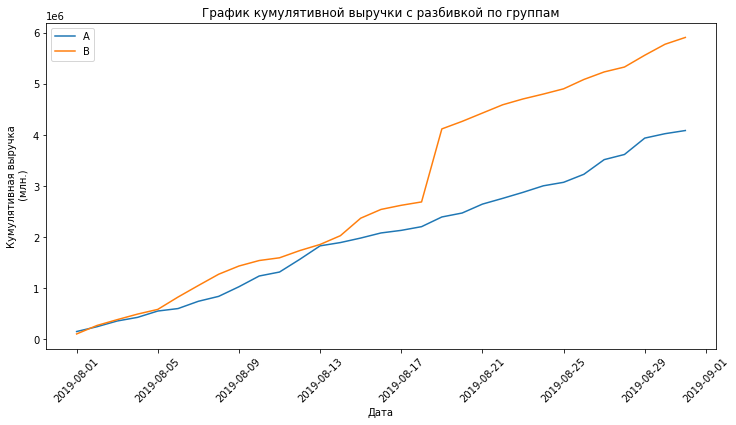

In [22]:
# задаём параметры графика
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)

# строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки с разбивкой по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка\n (млн.)')
plt.legend()

Как можем заметить, график относительно стабилизировался, начиная с конца августа. Однако, в период с 17 по 18 августа отслеживается резкий скачок прибыли, что может явно говорить о выбросах в виде анормально дорогих заказах или аномально высоком количестве покупок на пользователя.

#### График кумулятивного среднего чека по дням

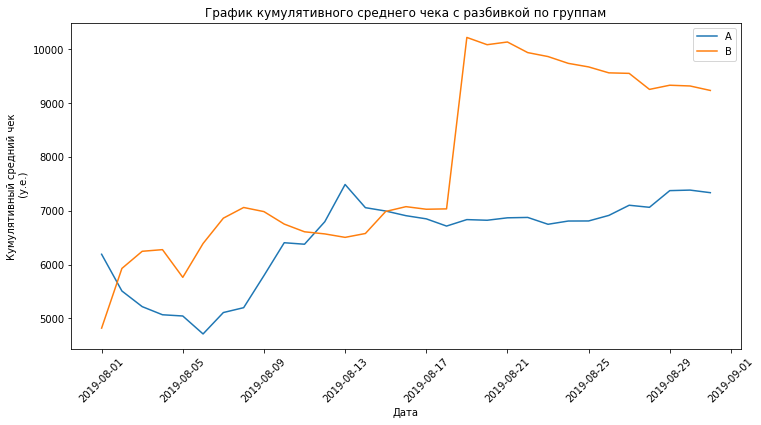

In [23]:
# задаём параметры графика
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)

# строим график среднего чека группы A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label = 'A')

# строим график среднего чека группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label = 'B')

plt.title('График кумулятивного среднего чека с разбивкой по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек\n (у.е.)')
plt.legend()
plt.legend() 

Как можем заметить, теория об аномально дорогом заказе в группе B подтверждается. 18 августа в группе B средний чек возрос в 2 раз, по сравнению с предыдущим днём.

#### График относительного изменения среднего чека

No handles with labels found to put in legend.


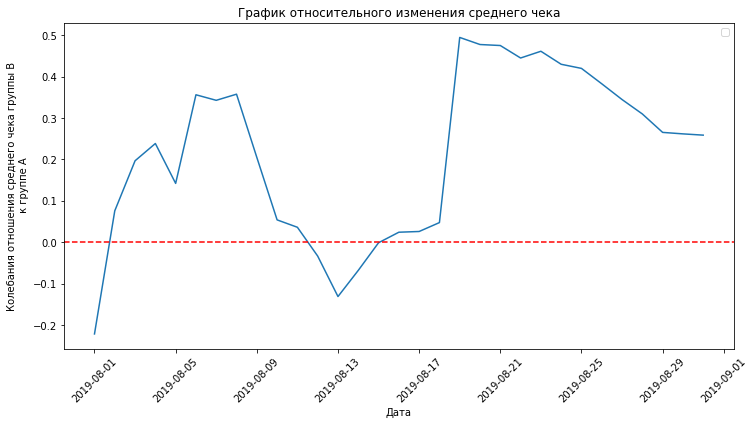

In [24]:
# объеденим таблицы с кумулятивными выручками по группам и построим график

mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)

# задаём параметры графика
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)

plt.plot(
    mergedCumulativeRevenue['date'], 
    (
        mergedCumulativeRevenue['revenueB']/
        mergedCumulativeRevenue['ordersB']
    )
    /
    (
        mergedCumulativeRevenue['revenueA']/
        mergedCumulativeRevenue['ordersA'])-1
)

plt.axhline(y=0, color='red', linestyle='--') 

plt.title('График относительного изменения среднего чека')
plt.xlabel('Дата')
plt.ylabel('Колебания отношения среднего чека группы В\n к группе А')
plt.legend()

Резкие скачки в нескольких датах дают четкое понимание о наличии выбросов. Так же, предварительно можно сказать по "сырым" данным, что после стабилизации показателей, группа В показывает бОльший на 30% средний чек, чем группа А.

#### График кумулятивной конверсии

In [25]:
# считаем и добавляем конверсию в датасет общих кумулятивных данных

cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

In [26]:
# разделяем данные по тестовым группам

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']

cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

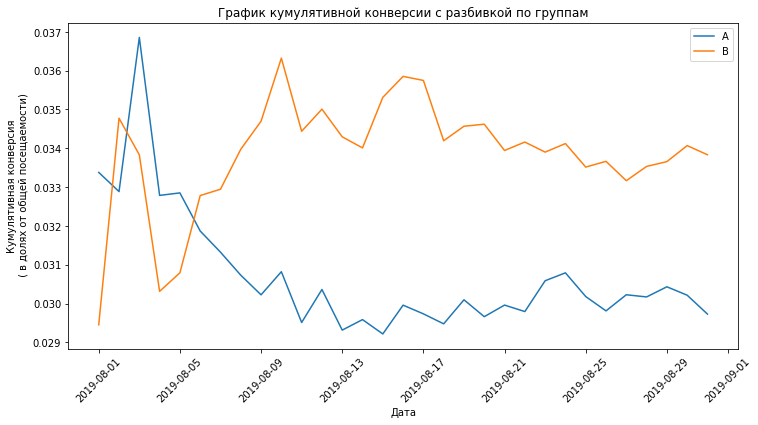

In [27]:
# задаём параметры графика
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')

plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')


plt.title('График кумулятивной конверсии с разбивкой по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия\n ( в долях от общей посещаемости)')
plt.legend()
plt.legend()

Как можем заметить, в конце месяца конверсии вышли на стабилизацию. Как можем заметить, группа B имеет лучшую относительную конверсию, примерно на 10%.

#### График относительного изменения конверсии

In [28]:
# объединяем таблицы с конверсиями
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


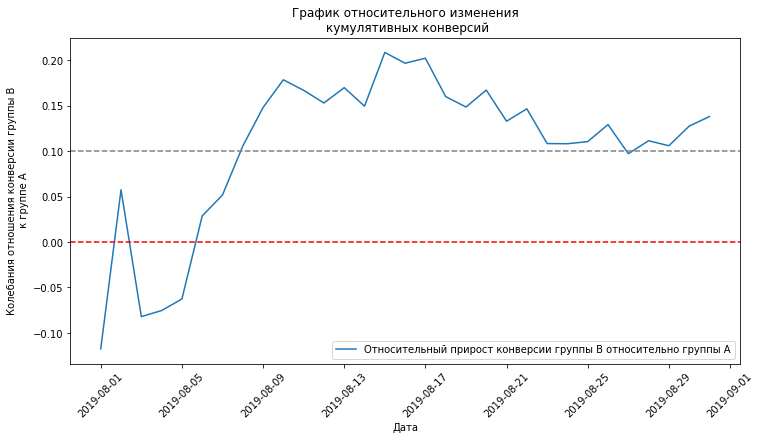

In [29]:
# задаём параметры графика
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)

# строим график
plt.plot(
    mergedCumulativeConversions['date'], 
    mergedCumulativeConversions['conversionB'] / 
    mergedCumulativeConversions['conversionA']-1, 
    label="Относительный прирост конверсии группы B относительно группы A"
)


plt.title('График относительного изменения\n кумулятивных конверсий')
plt.xlabel('Дата')
plt.ylabel('Колебания отношения конверсии группы В\n к группе А')
plt.legend()
plt.legend()

plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')

Как можем заметить по "сырым" данным, конверсия группы В имеет устойчивую тенденцию по доминации над группой А в 10%. Посмотрим, как изменится картина, после обработки выбросов и аномалий.

### Работа с выбросами и аномалиями

In [30]:
# получим таблицу с данными распределения количества заказов по пользователям

ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitorId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


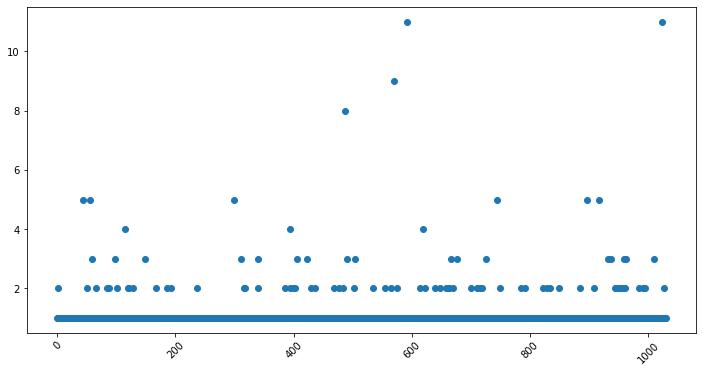

In [31]:
# строим график разброса кол-ва заказов на пользователя
# задаём параметры графика
plt.figure(figsize=(12, 6))
plt.xticks(rotation=45)

# список из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

Как можем заметить, большая часть пользователей осталась в пределах 3 заказов. Вычислим 95-ый и 99-ый перцентили и найдём границу выбросов.

In [32]:
# считаем перцентили
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Проведём границу по 95 перцентилю, оставим всех пользователей с 2 и менее заказами.

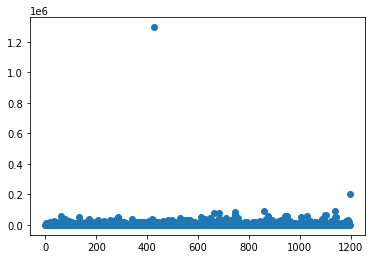

In [33]:
# построим график разброса по стоимости заказов

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

In [34]:
# считаем перцентили стоимости заказа
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Как можем заметить, 95% заказов были сделаны на сумму не более 28 тысяч. Проведём границу выбросов по этой величине.

#### Вывод

Изучив графики разбросов и перцинтили, отбросим всех пользователей, кто сделал более 2 заказов и заказы, на сумму более 28 тысяч.

### Статистический анализ

Перед началом анализа подготовим данные. Получим датасеты со списком пользователей и кол-вом их заказов.

* *Нулевая гипотеза:* выборки не имеют различий в среднем количестве заказов
* *Альтернативная гипотера:* выборки имеют различия в среднем количестве заказов

In [35]:
# получаем предварительные датасеты с пользователями, которые сделали 1 и более заказов

ordersByUsersA = (
    orders[
        orders['group']=='A'
    ].groupby(
        'visitorId', as_index=False
    ).agg(
        {
            'transactionId' : pd.Series.nunique
        }
    )
)
ordersByUsersA.columns = ['visitorId', 'orders']
 
ordersByUsersB = (
    orders[
        orders['group']=='B'
    ].groupby(
        'visitorId', as_index=False
    ).agg(
        {
            'transactionId' : pd.Series.nunique
        }
    )
)
ordersByUsersB.columns = ['visitorId', 'orders']
 

In [36]:
# Создаём окончательные выборки пользователей по группам. К предыдущим датасетам
# добавляем пользователей, кто не совершил ни одного заказа для корректностой проверки
# критерием Манна-Уитни

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0, 
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ), 
            name='orders'
        )
    ],
    axis=0
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0, 
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ), name='orders'
        )
    ],
    axis=0
)

#### Анализ "сырых" данных

In [37]:
# проверим критерием Манна-Уитни "сырые" выборки и
# получим относительную разницу в среднем кол-ве заказов

print('P-value = ', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Конверсия = ', "{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

P-value =  0.017
Конверсия =  0.138


*P-value* менее 0.05, а значит мы отвергаем нулевую гипотезу об отсутствии разницы в среднем количестве заказов. Конверсии в обеих выборках имеют стат.значимые различия в размере 13,8%.

Проверим критерием Манна-Уитни гипотезу о том, что средний чек в выборках имеет разницу.

* *Нулевая гипотеза:* выборки не имеют разницу в среднем чеке заказа
* *Альтернативная гипотеза:* выборки имеют разницу в среднем чеке заказа

In [38]:


print(
    'P-value = ',
    "{0:.3f}".format(
        stats.mannwhitneyu(
            orders[orders['group']=='A']['revenue'], 
            orders[orders['group']=='B']['revenue']
        )[1]
    )
)

print(
    'Разница в средних чеках = ',
    "{0:.3f}".format(
        orders[orders['group']=='B']['revenue'].mean()
        /
        orders[orders['group']=='A']['revenue'].mean()-1
    )
)

P-value =  0.729
Разница в средних чеках =  0.259


*P-value* значительно больше 0.05, а значит нету причин отвергать нулевую гипотезу. В средних чеках выборок нету различий, хотя группа B имеет средний чек на, почти, 26% больше, чем группа А. Разница в чеках не является статистически значимой.

#### Анализ "очищенных" данных

Очистим полученные ранее выборки от выбросов и аномалий по определённым ранее критериям, а именно: пользователи с 2 и менее заказами и чеком на сумму 28.000 и менее.

In [39]:
# получим список с аномальными пользователями

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[
            ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], [95, 99])[0]
        ]['visitorId'],
        ordersByUsersB[
            ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], [95, 99])[0]
        ]['visitorId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[
    orders['revenue'] > np.percentile(orders['revenue'], [95, 99])[0]
]['visitorId']

unnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [40]:
# выведем первые 10 строк полученного списка, а так же общее кол-во аномальных пользователей

print(unnormalUsers.head(10))
print(unnormalUsers.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
684     358944393
648     382846391
1189    393266494
68      457167155
68      611059232
Name: visitorId, dtype: int64
74


Всего 74 аномальных пользователя. Пересоздадим выборки с условием исключения аномальных пользователей.

In [41]:
sampleA = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(unnormalUsers))
        ]['orders'],
        pd.Series(
            0, 
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ), 
            name='orders'
        )
    ],
    axis=0
)

sampleB = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(unnormalUsers))
        ]['orders'],
        pd.Series(
            0, 
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ), name='orders'
        )
    ],
    axis=0
)

Формулировка нулевой и альтернативной гипотез для проверки стат.значимости различий среднего кол-ва заказов остаётся той же:

* *Нулевая гипотеза:* выборки не имеют различий в среднем количестве заказов
* *Альтернативная гипотера:* выборки имеют различия в среднем количестве заказов

In [42]:
print('P-value = ', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Конверсия = ', "{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

P-value =  0.013
Конверсия =  0.173


P-value уменьшился, что вновь подтверждает верность альтернативной гипотезы о стат.значимом различии конверсии. Среднее количество заказов группы В превосходит группу А на 17,3%.

Формулировка нулевой и альтернативной гипотез для проверки стат.значимости различий размера среднего чека так же остаётся той же:

* *Нулевая гипотеза:* выборки не имеют разницу в среднем чеке заказа
* *Альтернативная гипотеза:* выборки имеют разницу в среднем чеке заказа

In [43]:
# проверяем выборки критерием Манн-Уитни, с условием исключения аномальных пользователей.

print(
    'P-value = ',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(unnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(unnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Разница средних чеков = ',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(unnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(unnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value =  0.738
Разница средних чеков =  -0.020


*P-value* так же остаётся выше 0.05, а значит у нас по прежднему нету причин отвергать нулевую гипотезу. Группа В потеряла домнирование, теперь она имеет на 2% меньший чек, чем группа А. Стоит предположить, что на разницу в чеках повлияла числа аномально дорогих заказов.

## Вывод.

Подводя итоги, можно сказать, что:

* Имеется статистически значимое различие в среднем количестве заказов между групп и в "сырых", и в очищенных данных.

* Отсутствует статистически значимое различие в среднем чеке между групп ни в "сырых", ни в очищенных данных.

* График относительного изменения кумулятивного среднего чека стабилизировался или имеет тентенцию к падению. После устранения аномально дорогих заказов, группа В показала средний чек на 2% хуже, чем группа А.

* График относительной кумулятивной конверсии говорит о лучшей конверсии в группе В и относительно стабилизировался. Нету тенденции к её изменению.

Исходя из этого можно остановить тест и признать его успешным. Нам удалось повысить среднее количество заказов на 17,3%. Не смотря на относительное уменьшение среднего чека на 2%, оно не имеет статистической значимости. 